### SUPERCONDUCTIVITY EXAMPLE WITH ROOT

In a superconductivity experiment, a four-wire technique was used to simultaneously measure the voltage across a superconducting sample of unknown material. Using the experimental data from this experiment, you will calculate the resistance and determine the critical temperature $T_c$ for the superconducting sample, and determine its identity.

Superconductors are characterized by a critical temperature, Tc, below which they have zero resistance. In the broadest terms, there are two classes of superconductors. There are those with low values for TC, typically 10 K or less, and those with much higher TC. Some of the high-TC materials at atmospheric pressures can get up to 150 K while still being superconductors. 

The high-TC material you will examine in this experiment is one of two different cuprates. The first is YBa2Cu3O7. In this material the stoichiometric ratio of Y, Ba, and Cu is 1,2,3 and hence it is sometimes called a “123” superconductor. The number of Oxygen atoms present is key to the superconducting properties of the sample. It is also known as “YBCO”. The structure is related to that of perovskites.

The other sample is Bi-Sr-Ca-Cu-oxide. Several different compounds are present in the sample, but the one giving rise to the properties we will observe is BiSr2Ca2Cu3O10. It will show superconducting properties at even higher temperatures than the YBCO sample. The abbreviation BSCCO frequently gets pronounced as “Bis - co”.

Experimentally, Tc is most often taken to be at the transition point of the resistance vs. temperature plot - the onset of the transition (if you are warming up from LN2 temperature) back to normal resistance behavior. This temperature must be determined as accurately as possible. You must understand the limitations of the system and determine a reasonable uncertainty in your temperature results. When you compare your numbers to those available elsewhere (cite your sources), you must realize that our samples may be somewhat different and not look exactly like those published elsewhere. Lastly, even in the best samples and experiments there appears to be a natural width of a few degrees Kelvin which corresponds to the onset of superconductivity. This itself is not entirely understood and a bit at odds with the (easier to explain) low-temperature superconductors, which typically exhibit a “sharper” transition.

Your tasks are:

1) Plot Resistance vs Temperature with error bars.
2) Consider an analysis methods for identifying the important features of your plot. You may choose to take one or more numerical derivatives to locate the temperature of interest. You may also choose to fit an appropriate analytical function to your data, to allow extraction of appropriate fit parameters. I suggest fitting a sigmoid:

$$S(x) = \frac{L}{1+e^{-k(x-x_0)}}$$

Where L: Height, k: steepness, x0: center

3) Determine the onset temperature of the transition where the resistance begins to in- crease from zero, with uncertainty. Feel free to estimate your uncertainties as constant values measured by the Keithley 2000 multiplier or just use least count.
4) Compare your temperature to literature values for your superconducting sample. The onset temperature value should agree within reasonable uncertainties, but there may be differences. One plausible explanation for this relates to the size of the ceramic superconducting disk and that the temperature across it may not be uniform. Try to articulate why this might produce an effect in your measurements. Ultimately, you should be able to tell if our sample is YBCO or BSCCO.

The purpose of this exercise is to give you a first order of understanding how to work with experimental data. The source file you have needs to be cleaned first, as only the rows with three columns are the ones that contain valuable data (the other ones are noise). Moreover, I want you to have a first and simple use case of ROOT plotting tools, so you should not use matplotlib or any other python libraries, do all your plots with ROOT. Also, you cannot use any fitting method other than the ones that come with ROOT, but you can use Numpy and Pandas if you want for simple data management and operations, but not for fittings. 

STEP 1: Import ROOT and other required packages

In [78]:
# ---------------------------------------------------------------------------------------------
# IMPORT ROOT AND ARRAY (a module used to convert Python lists to arrays compatible with ROOT)
# ---------------------------------------------------------------------------------------------
import ROOT
from array import array

# ---------------------------------------------------------------------------------------------
# IMPORT OTHER USEFUL PACKAGES
# ---------------------------------------------------------------------------------------------
import numpy as np
import pandas as pd


STEP 2: Modularize code by creating functions

In [79]:
# ---------------------------------------------------------------------------------------------
# DEFINING A FUNCTION THAT CLEANS THE DATA 
# ---------------------------------------------------------------------------------------------
def CLEAN_INPUT(file):
    # cleaning superconductor data
    data = []
    clean_data = []

    # extract raw data
    f = open(file, 'r')
    for line in f:
        data.append(line)
    f.close()

    for i in range(0, len(data)):
        # broken apart by spaces
        temp = data[i].split(' ')
        if len(temp) == 3:
            clean_data.append(temp)
            # gets rid of newline in str
            clean_data[-1][-1] = clean_data[-1][-1].replace('\n','')

    # convert str to flt
    clean_data = np.array(clean_data, dtype = float)
    return clean_data

# ---------------------------------------------------------------------------------------------
# DEFINING A FUNCTION THAT RETURNS THE UNCERTAINTY USING VARIATIONAL METHOD 
# ---------------------------------------------------------------------------------------------
def uncertainty_var(values, deltas, function):
    values, deltas = np.array(values), np.array(deltas)
    delta_matrix = deltas*np.identity(values.shape[0])
    sum = 0
    for delta in delta_matrix:
        sum += (0.5*(abs(function(values + delta) - function(values)) + abs(function(values-delta) - function(values))))**2
    return np.sqrt(sum)

# ---------------------------------------------------------------------------------------------
# DEFINING A FUNCTION THAT CALCULATES THE RESISTANCE HAVING VOLTAGE AND CURRENT AS INPUTS 
# ---------------------------------------------------------------------------------------------
calculate_R = lambda param : abs(param[0]/param[1]) # param = [V, I]


STEP 3: Read and clean your data 

In [80]:
# ---------------------------------------------------------------------------------------------
# CLEANING OUR DATA AND STORING IT IN A PANDAS DATAFRAME
# ---------------------------------------------------------------------------------------------
data = CLEAN_INPUT('warmingdata.txt') # I (mA), Voltage (mV), Temperature (K)
df = pd.DataFrame(data, columns=['I (mA)', 'Voltage (mV)', 'Temperature (K)'])
df['I (mA)'] = df['I (mA)']*1e2
df['Voltage (mV)'] = df['Voltage (mV)']*1e3
df['Resistance ($\Omega$)'] = df['Voltage (mV)']/df['I (mA)']
df = df[(df['Resistance ($\Omega$)']<1.25e-2) | (df['Resistance ($\Omega$)']>1.49e-2)] # Adjusting vertical range to fit data

# ---------------------------------------------------------------------------------------------
# ADDING UNCERTAINTIES TO OUR DATASET
# ---------------------------------------------------------------------------------------------
df['$\Delta$ V (mV)'], df['$\Delta$ I (mA)'], df['$\Delta$ T (K)'] = 0.01, 0.01, 0.01
df['$\Delta$ R ($\Omega$)'] = df.apply(lambda x: uncertainty_var([x['Voltage (mV)'], x['I (mA)']], [x['$\Delta$ V (mV)'], x['$\Delta$ I (mA)']], calculate_R), axis=1)
df = df[(df['Temperature (K)'] > 100)] # Making a cut to improve sigmoid approximation
df.head(5)

,I (mA),Voltage (mV),Temperature (K),Resistance ($\Omega$),$\Delta$ V (mV),$\Delta$ I (mA),$\Delta$ T (K),$\Delta$ R ($\Omega$)
85,100.051671,-0.000018,100.083911,-1.848838e-07,0.01,0.01,0.01,0.000100
86,100.049473,-0.001050,100.346229,-1.049612e-05,0.01,0.01,0.01,0.000089
87,100.049900,-0.001066,100.606246,-1.065554e-05,0.01,0.01,0.01,0.000089
88,100.051303,-0.000051,100.883340,-5.056752e-07,0.01,0.01,0.01,0.000099
89,100.055370,-0.000115,101.192219,-1.147418e-06,0.01,0.01,0.01,0.000099


STEP 4: Plot our data

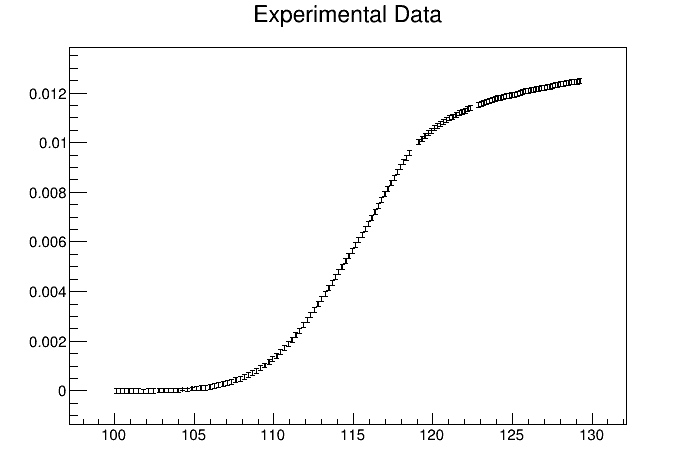

In [81]:
# ---------------------------------------------------------------------------------------------
# EXTRACT OUT DATA FROM THE PANDAS DATAFRAME
# ---------------------------------------------------------------------------------------------
xdata, ydata, error_x, error_y = df['Temperature (K)'], df['Resistance ($\Omega$)'], df['$\Delta$ T (K)'], df['$\Delta$ R ($\Omega$)']

# ---------------------------------------------------------------------------------------------
# PLOT DATA WITH UNCERTAINTIES USING ROOT
# ---------------------------------------------------------------------------------------------
g = ROOT.TGraphErrors(len(xdata), array('d',xdata), array('d',ydata), array('d',error_x), array('d',error_y))
c4 = ROOT.TCanvas()
g.Draw('ap')
g.SetTitle('Experimental Data')
c4.Draw()

STEP 5: Fit to sigmoid

In [82]:
# ---------------------------------------------------------------------------------------------
# DEFINE OUR C++ FUNCTION TO FIT (ROOT NEEDS THIS FUNCTION TO BE IN C++)
# par = [L, k, x0] where L: Height, x0: center, k: steepness
# ---------------------------------------------------------------------------------------------

In [83]:
%%cpp
double sigmoid(double *x, double *par){
    return par[0]/(1 + TMath::Exp(-par[2]*(x[0]-par[1])));
}

In [89]:
# ---------------------------------------------------------------------------------------------
# FITTING TO OUR SIGMOID FUNCTION
# ---------------------------------------------------------------------------------------------
fitFunc = ROOT.TF1("fitFunc", ROOT.sigmoid, xdata.min(), xdata.max(), npar=3)
fitFunc.SetParameters(0.01723423,120.092662,1.14455349) # Making a parameter estimation
res = g.Fit(fitFunc, "S") 
parameter_values = [fitFunc.GetParameter(i) for i in range(3)]

 FCN=176.303 FROM MIGRAD    STATUS=CONVERGED     139 CALLS         140 TOTAL
                     EDM=2.17287e-12    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.0 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.23106e-02   1.97998e-05  -9.75811e-09  -1.76550e-01
   2  p1           1.15375e+02   1.98340e-02   4.36950e-06   2.55477e-05
   3  p2           3.83291e-01   2.41606e-03   2.33770e-06  -1.24955e-03


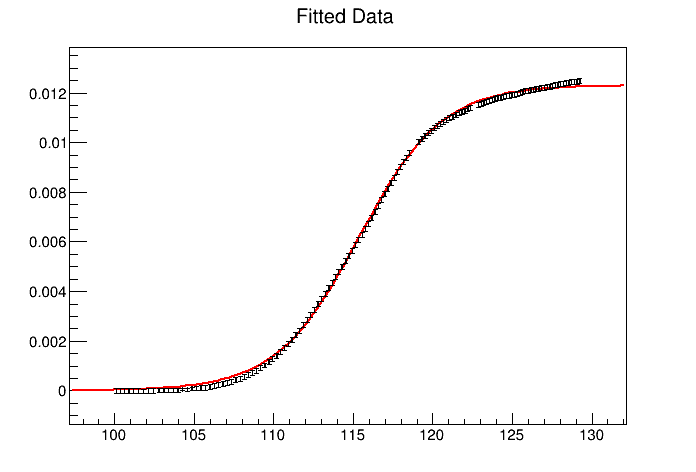

In [90]:
# ---------------------------------------------------------------------------------------------
# PLOTTING OUR FITTED FUNCTION
# ---------------------------------------------------------------------------------------------
c2 = ROOT.TCanvas()
g.Draw('ap')
g.SetTitle('Fitted Data')
c2.Draw()

STEP 6: FINDING THE CRITICAL TEMPERATURE

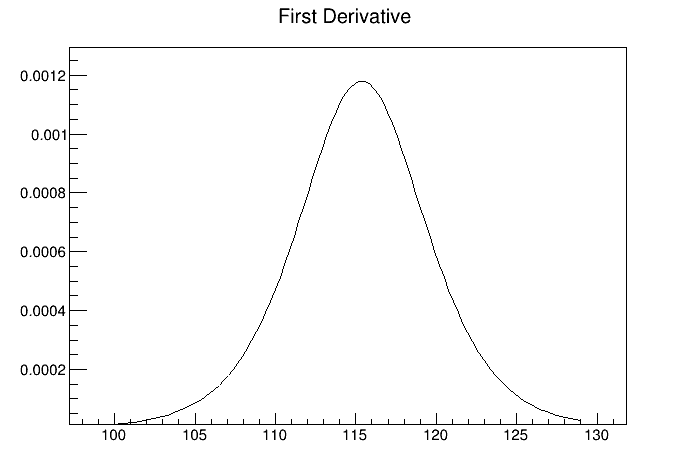

In [91]:
# ---------------------------------------------------------------------------------------------
# TAKING THE NUMERICAL DERIVATIVE TO FIND MAX RATE OF CHANGE
# ---------------------------------------------------------------------------------------------
derivativeGraph = ROOT.TGraph()

num_points = 100
x_min = xdata.min()
x_max = xdata.max()
step = (x_max - x_min) / num_points
xdata2, ydata2 = [], []

for i in range(num_points):
    x = x_min + i * step
    xdata2.append(x)
    derivative_value = fitFunc.Derivative(x)
    ydata2.append(derivative_value)
    derivativeGraph.SetPoint(i, x, derivative_value)

c = ROOT.TCanvas()
derivativeGraph.Draw("AL")
derivativeGraph.SetTitle('First Derivative')
c.Draw()

In [92]:
# ---------------------------------------------------------------------------------------------
# EXTRACTING CRITICAL TEMPERATURE
# ---------------------------------------------------------------------------------------------
TC = xdata2[ydata2.index(max(ydata2))]
delta_T = parameter_values[2]

from IPython.display import display, Latex
display(Latex('Critical Temperature: ({:.1f} $\pm$ {:.1f}) K'.format(TC, delta_T)))

<IPython.core.display.Latex object>

STEP 7: Determine the superconducting sample

In [93]:
known_temp = 108
error = abs((known_temp - TC)/known_temp)*100
error

6.7037532962962905

Our superconducting sample seems to be bismuth strontium calcium copper oxide (BSCCO), which has a critical temperature of 108 K. This represents an experimental percentage error of $6.7\%$. 